In [1]:
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

In [2]:
import sys
sys.path.append('../')

In [3]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [4]:
isess = tf.InteractiveSession()

## Drawing routines

In [82]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+20, p1[1]+5)
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
    

## Pascal VOC dataset

Check the data pipeline and TFRecords files.

In [68]:
from datasets import pascalvoc_2007

DATASET_DIR = '/media/paul/DataExt4/VOC2007/Dataset/'
SPLIT_NAME = 'train'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = pascalvoc_2007.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, shuffle=False,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bbox, label] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])

In [7]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [300, 500, 3])

print(image.get_shape())
print(image_crop.get_shape())
print(bbox.get_shape())
print(label.get_shape())

(?, ?, 3)
(300, 500, 3)
(?, 4)
(?,)


In [85]:
# Read records from the queue.
with tf.Session() as sess:
#     with queues.QueueRunners(sess):
    # Start populating the filename queue.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    result = sess.run([image_crop, shape, bbox, label])
    result = sess.run([image_crop, shape, bbox, label])
    result = sess.run([image_crop, shape, bbox, label])
    
    # Request threads to stop. Just to avoid error messages
    coord.request_stop()
    coord.join(threads)


(300, 500, 3)
[375 500   3]
[[ 0.45866665  0.138       0.88        0.54000002]
 [ 0.37599999  0.30000001  0.75733334  0.458     ]
 [ 0.53600001  0.56999999  0.88266665  0.65399998]
 [ 0.528       0.51599997  0.87733334  0.59399998]]
[6 1 1 1]


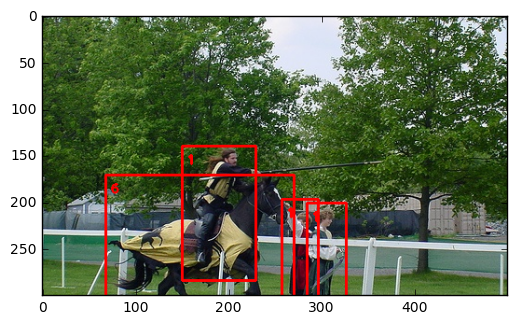

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = result[0]
img_shape = result[1]
bboxes = result[2]
for i in range(bboxes.shape[0]):
    draw_bbox(img, bboxes[i], img_shape, result[3][i], color=[255, 0, 0])

print(img.shape)
print(img_shape)
print(bboxes)
print(result[3])

plt.imshow(img)

In [10]:
images = tf.train.batch(
                [image2],
                batch_size=BATCH_SIZE,
                num_threads=1,
                capacity=5 * BATCH_SIZE)

NameError: name 'image2' is not defined

In [ ]:
# images.eval()

In [ ]:


a = tf.constant(5.0)
b = tf.constant(7.0)
c = a * b
# We can just use 'c.eval()' without passing 'sess'
print(c.eval())


In [ ]:
sess.close()